In [5]:
%%time
# Import required libraries
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

import os
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

import datetime
#print(datetime.datetime.now())

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel

from sklearn.externals import joblib
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Wall time: 1.02 ms


In [6]:
# using standardized and non standardies data
# run logistic, knn, svm, rf, gbm, xgboost, lightgbm, keras
# get acc, F1, precision, recall, auc

In [7]:
data = pd.read_csv('../data/processed/data_for_modeling.csv')
X_train, X_test, y_train, y_test=train_test_split(data.iloc[:,1:],data.iloc[:,0], test_size=0.15, random_state=20)

## Linear Regression

In [4]:
%%time
param_grid = [
    {'penalty':['l1','l2'],
    'C': [.01,.1,.05]}
]
logiReg2 = LogisticRegression()
lr_gridSearch2 = GridSearchCV(logiReg2,param_grid,cv=5,verbose=10, n_jobs=4)
lr_gridSearch2.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 35.3min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed: 66.0min remaining:  7.3min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 70.4min finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 1h 10min 43s


In [210]:
lr_gridSearch2.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
lr_gridSearch2.best_score_

0.7946323424514606

In [3]:
#joblib.dump(lr_gridSearch2,'../models/lr_gridSearch2.pkl')
lr_gridSearch2=joblib.load('../models/lr_gridSearch2.pkl')

In [4]:
lr_pred=lr_gridSearch2.predict(X_test)
lr_pred_prob=lr_gridSearch2.predict_proba(X_test)

In [5]:
lr_pred_prob

array([[0.74749739, 0.25250261],
       [0.91652446, 0.08347554],
       [0.73503688, 0.26496312],
       ...,
       [0.68770949, 0.31229051],
       [0.80987922, 0.19012078],
       [0.8999146 , 0.1000854 ]])

In [53]:
lr_gridSearch2.predict(X_test).sum()

5596

In [59]:
y_test.sum()

26431

## Naive Bayes

In [6]:
gnb = GaussianNB()
gnb_scores= cross_val_score(gnb,X_train,y_train,cv=5)

In [7]:
gnb_scores

array([0.66482748, 0.58022196, 0.56966929, 0.5582215 , 0.58849486])

## SVM Using Stocastic gradient decent and calibarated for probability generation

In [15]:
%%time
svm_sgd_clf = SGDClassifier(loss='hinge', tol=.001, max_iter=1000)
svm_sgd_param = [
    {'alpha': [0.001,0.0001,0.00001],
     'penalty': ['l1','l2']

    }
]
svm_sgd_gridsearch = GridSearchCV(svm_sgd_clf,svm_sgd_param,cv=5,verbose=10, n_jobs=4 )
svm_sgd_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   33.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   47.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:  5.6min remaining:   37.2s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  6.1min finished


Wall time: 6min 16s


In [16]:
svm_sgd_gridsearch.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
joblib.dump(svm_sgd_gridsearch,'../models/svm_sgd_gridsearch.pkl')
#svm_sgd_gridsearch=joblib.load('../models/svm_sgd_gridsearch.pkl')

['../models/svm_sgd_gridsearch.pkl']

In [19]:
#svm_pred=svm_sgd_gridsearch.predict(X_test)
#svm_pred_prob=svm_sgd_gridsearch.predict_proba(X_test)

In [20]:
svm_sgd_caliberated = CalibratedClassifierCV(svm_sgd_clf, cv=5, method='isotonic')

In [21]:
%%time 
svm_sgd_caliberated.fit(X_train,y_train)

Wall time: 1min 34s


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='isotonic')

In [22]:
#joblib.dump(svm_sgd_gridsearch,'../models/svm_sgd_caliberated.pkl')
svm_sgd_caliberated=joblib.load('../models/svm_sgd_caliberated.pkl')

In [24]:
#svm_sgd_caliberated.predict_proba(X_train)

In [60]:
svm_pred=svm_sgd_caliberated.predict(X_test.values).sum()

## XGBoost

In [30]:
dtrain = xgb.DMatrix( X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [95]:
%%time
xgb_classifier = xgb.XGBClassifier(n_jobs=4)
kfold = KFold(n_splits=5,random_state=20)
xgb_param = [
    {'max_depth': [2,4,6],
     'n_estimator': [50,100,200]
     
    }
]
xgb_score = GridSearchCV(xgb_classifier,xgb_param,cv=5,verbose=1)
xgb_score.fit(X_train,y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 72.8min finished


Wall time: 1h 15min 36s


In [106]:
xgb_score.best_score_

0.7964561543862397

In [107]:
xgb_score.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimator=50,
       n_estimators=100, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [108]:
xgb_train2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimator=50,
       n_estimators=100, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [109]:
xgb_train2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimator=50,
       n_estimators=100, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

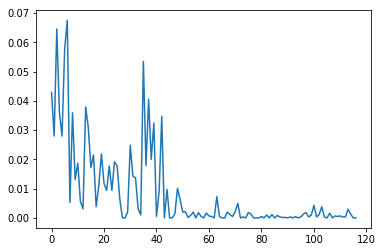

In [132]:
xgb_train2.feature_importances_
plt.plot(xgb_train2.feature_importances_)

In [151]:
xgb_top_feature = SelectFromModel(xgb_train2, threshold=.02,prefit=True)
xgb_top_data = xgb_top_feature.transform(data.iloc[:,1:])

(841160, 18)

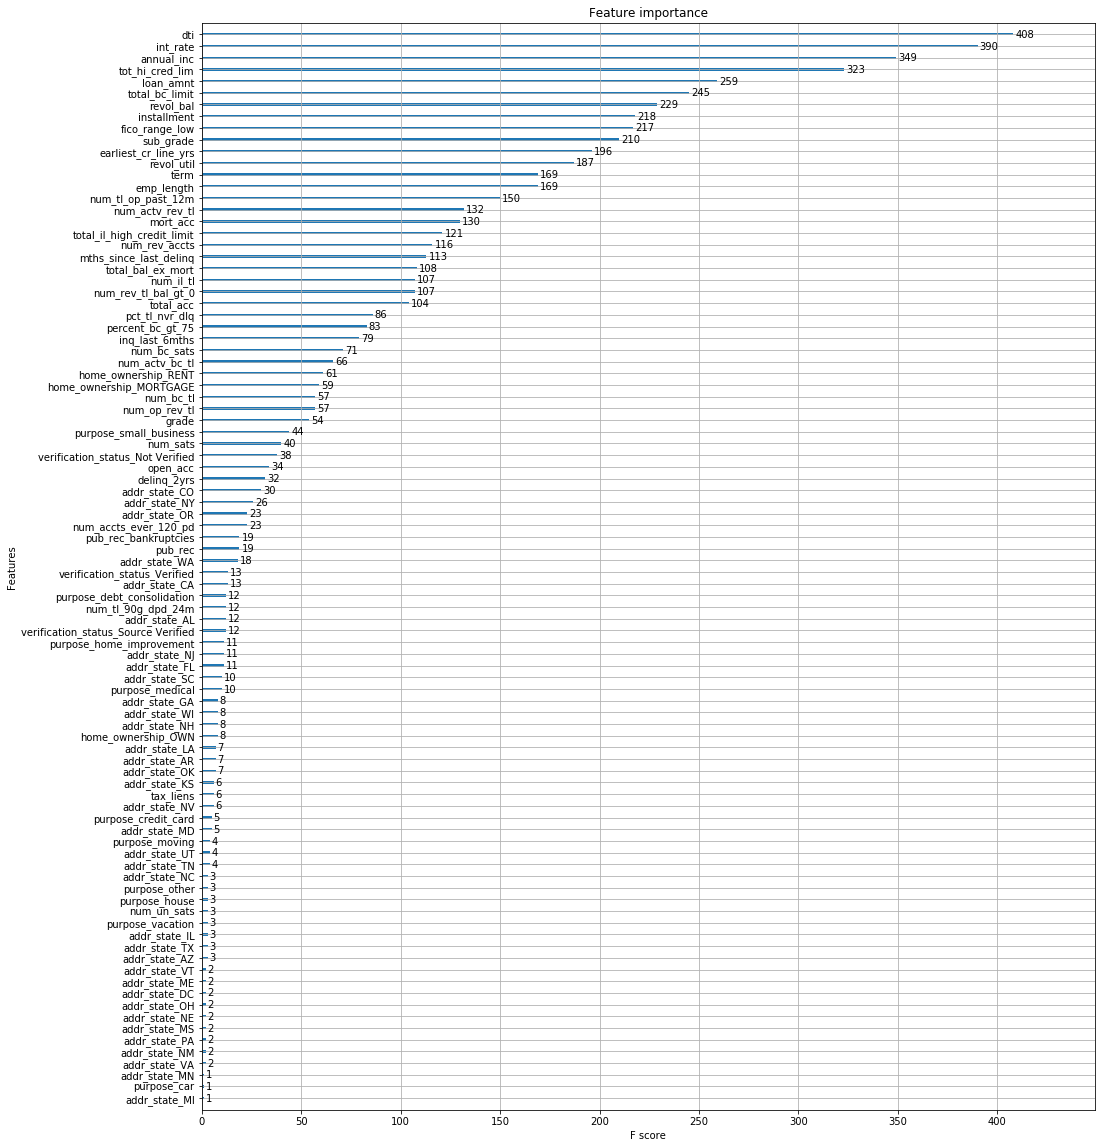

In [123]:
fig,ax = plt.subplots(1,1,figsize=(16,20))
xgb.plot_importance(xgb_train2,ax=ax)


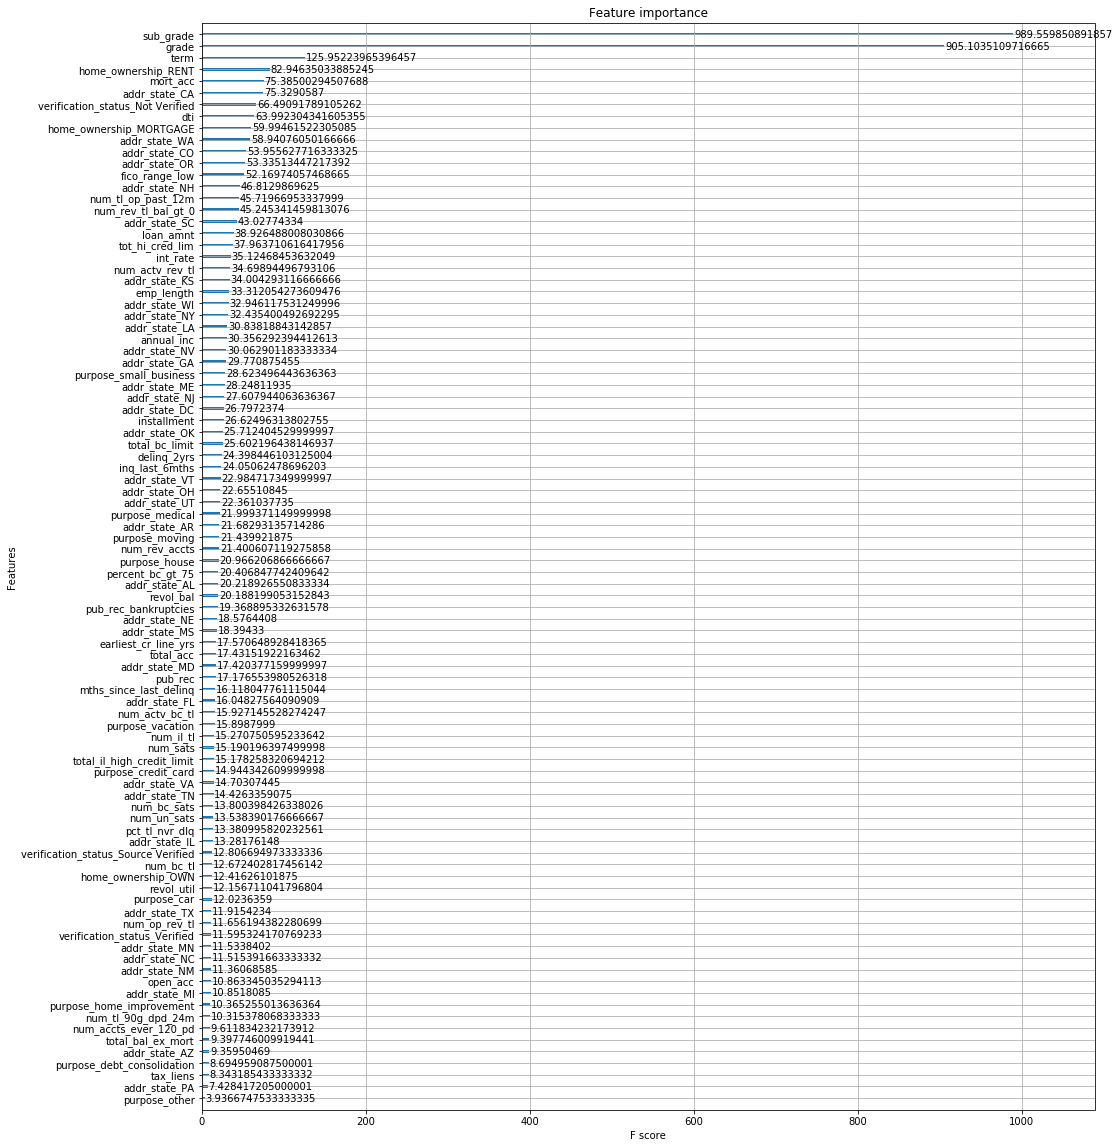

In [124]:
fig,ax = plt.subplots(1,1,figsize=(16,20))
xgb.plot_importance(xgb_train2,ax=ax,importance_type='gain')

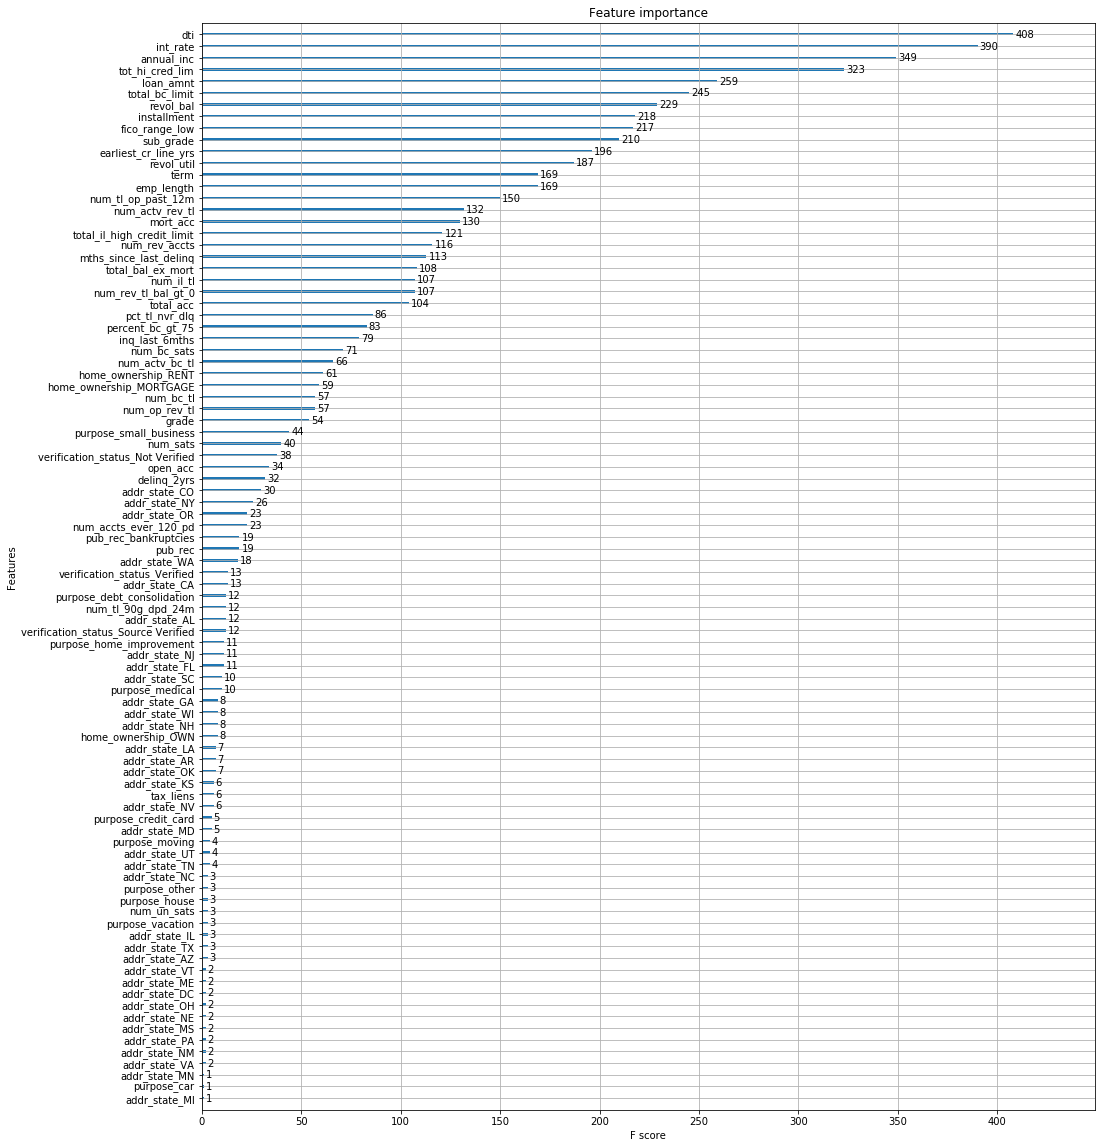

In [125]:
fig,ax = plt.subplots(1,1,figsize=(16,20))
xgb.plot_importance(xgb_train2,ax=ax,importance_type='weight')

In [130]:
xgb_train2.booster

'gbtree'

In [ ]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(gbm, threshold=0.03, prefit=True)
selected_dataset = selection.transform(X_test)

In [31]:
#joblib.dump(xgb_score,'../models/xgb_score.pkl')
xgb_score=joblib.load('../models/xgb_score.pkl')

In [32]:
xgb_pred=xgb_score.predict(X_test)
xgb_pred_prob=xgb_score.predict_proba(X_test)

In [33]:
xgb_pred_prob

array([[0.77004063, 0.22995935],
       [0.8847012 , 0.11529883],
       [0.71150124, 0.2884988 ],
       ...,
       [0.69933516, 0.30066484],
       [0.8504752 , 0.1495248 ],
       [0.84273493, 0.15726504]], dtype=float32)

In [50]:
xgb_score.predict(X_test).sum()

4670

## LightGBM

In [34]:
lgb_train = lgb.Dataset( X_train,label=y_train)
lgb_test = lgb.Dataset(X_test,label=y_test, reference=lgb_train)

In [96]:
%%time
lgb_classifier = lgb.LGBMClassifier(objective='binary', n_jobs=4, silent=False)
lgb_param = [
    {
        'num_leaves': [31,79,127],
        'n_estimators': [50,100,200],
        'learning_rate': [.01,.1]
        
    }
]
lgb_score = GridSearchCV(lgb_classifier,lgb_param,cv=5,verbose=10)
lgb_score.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=0.7899900697911859, total=   7.3s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=0.7899886011594649, total=   7.3s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.0s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=0.7899886011594649, total=   7.2s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=0.7899886011594649, total=   7.2s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.1s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=0.7899886011594649, total=   7.4s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=79 ..............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.8s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=79, score=0.7899900697911859, total=   9.2s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=79 ..............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   59.4s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=79, score=0.7899886011594649, total=   9.6s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=79 ..............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=79, score=0.7899886011594649, total=   9.3s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=79 ..............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=79, score=0.7899886011594649, total=   9.2s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=79 ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=79, score=0.7899886011594649, total=   9.2s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=127 .............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=127, score=0.7899900697911859, total=  10.5s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=127 .............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=127, score=0.7899886011594649, total=  10.8s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=127 .............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=127, score=0.7899886011594649, total=  10.7s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=127 .............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=127, score=0.7899886011594649, total=  10.5s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=127 .............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=127, score=0.7899886011594649, total=  10.7s
[CV] learning_rate=0.01, n_estimators=100, num_leave

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 27.5min finished


Wall time: 27min 48s


In [100]:
lgb_score.best_score_

0.7976715627998311

In [101]:
lgb_score.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=4, num_leaves=79, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [103]:
lgb_train2 = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=4, num_leaves=79, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [104]:
lgb_train2.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=4, num_leaves=79, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [111]:
lgb_train2.feature_importances_

array([ 592,  193, 1235,  560,  378,  826,  865,   80,  395,  145,  347,
        182,   69,  642,  595,  356,  290,   84,  178,  223,  191,  233,
        355,  160,  370,  206,  139,    0,    2,   29,  297,  289,  252,
         55,   32,  654,  404,  677,  432,  535,   31,  107,  403,    0,
         55,    0,    0,   33,   93,   70,   36,   44,   12,   32,   41,
          0,   35,   17,   17,   26,   24,   24,    3,   59,   20,    8,
          2,   27,   22,   17,   43,   50,   10,   13,    1,   23,   30,
         16,    0,    5,   17,    7,   17,    5,   25,    4,   21,   12,
          2,    7,    7,   12,    9,    5,    0,    8,   22,   45,    6,
         26,   47,   20,   25,   45,   13,    9,   33,    2,   13,   19,
         17,   11,   15,   39,   26,   10,    3])

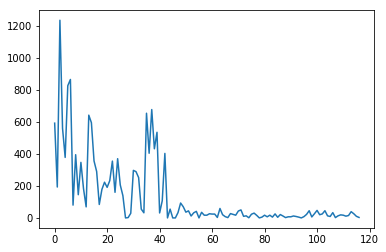

In [140]:
lgb_train2.feature_importances_
plt.plot(lgb_train2.feature_importances_)


In [150]:
lgb_top_feature = SelectFromModel(lgb_train2, threshold=100,prefit=True)
lgb_top_data = lgb_top_feature.transform(data.iloc[:,1:])

In [143]:
lgb_top_data

(841160, 34)

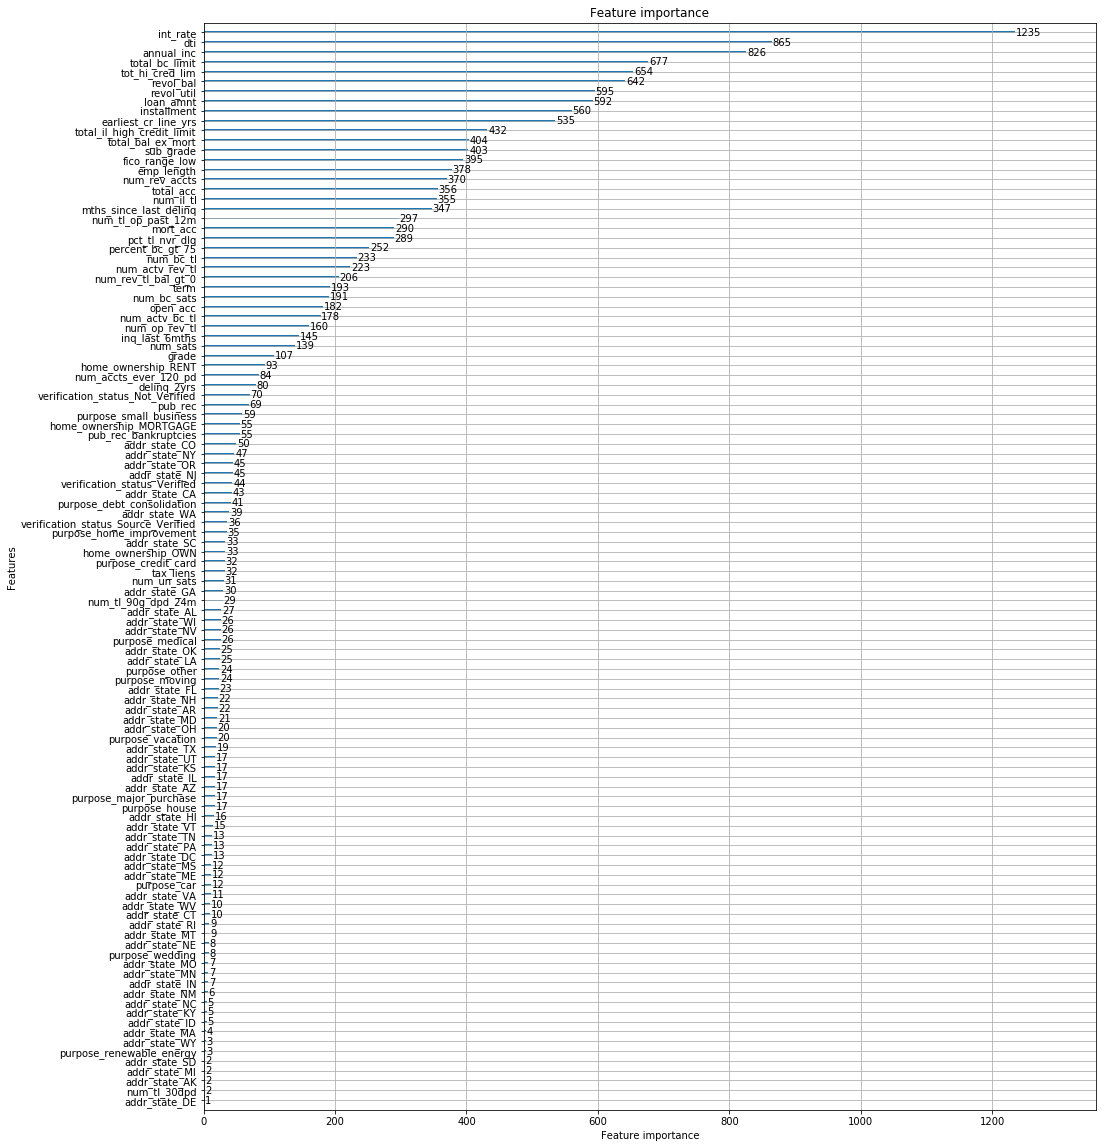

In [121]:
fig,ax = plt.subplots(1,1,figsize=(16,20))
lgb.plot_importance(lgb_train2,ax=ax)


In [35]:
#joblib.dump(lgb_score,'../models/lgb_score.pkl')
lgb_score=joblib.load('../models/lgb_score.pkl')

In [37]:
lgb_pred=lgb_score.predict(X_test)
lgb_pred_prob=lgb_score.predict_proba(X_test)

In [38]:
lgb_pred_prob

array([[0.80507014, 0.19492986],
       [0.88784283, 0.11215717],
       [0.72585702, 0.27414298],
       ...,
       [0.68669658, 0.31330342],
       [0.86791053, 0.13208947],
       [0.86964932, 0.13035068]])

In [49]:
lgb_score.predict(X_test).sum()

5954

## Tensorflow Keras Deeplearing

In [39]:
tf_model = tf.keras.Sequential([
    keras.layers.Dense(128,activation=tf.nn.relu),
    keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dense(32,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
  ])

tf_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])


In [40]:
%%time
tf_model.fit(X_train.values,y_train.values,epochs=5)
tf_loss, tf_acc = tf_model.evaluate(X_test.values,y_test.values)
print("Test Acc: ",tf_acc)

Epoch 1/5
714986/714986 [==============================] - 79s 111us/step - loss: 0.4622 - acc: 0.7947
Epoch 2/5
714986/714986 [==============================] - 71s 99us/step - loss: 0.4575 - acc: 0.7959
Epoch 3/5
714986/714986 [==============================] - 71s 99us/step - loss: 0.4559 - acc: 0.7964
Epoch 4/5
714986/714986 [==============================] - 72s 100us/step - loss: 0.4547 - acc: 0.7969
Epoch 5/5
126174/126174 [==============================] - 5s 38us/step
Test Acc:  0.7938640290430424
Wall time: 6min 10s


In [61]:
tf_pred_prob=tf_model.predict(X_test.values)
tf_pred=tf_model.predict_classes(X_test.values)

### Compare confustion table, precision/recall, ROC

In [ ]:
lr_pred
xgb_pred
lgb_pred
tf_pred

lr_pred_prob
gnb_scores
xgb_pred_prob
lgb_pred_prob
tf_pred_prob

In [70]:
confusion_matrix(y_test,lr_pred)

array([[97215,  2528],
       [23363,  3068]], dtype=int64)

In [73]:
confusion_matrix(y_test,xgb_pred)

array([[97800,  1943],
       [23704,  2727]], dtype=int64)

In [74]:
confusion_matrix(y_test,lgb_pred)

array([[97222,  2521],
       [22998,  3433]], dtype=int64)

In [75]:
confusion_matrix(y_test,tf_pred)

array([[94939,  4804],
       [21205,  5226]], dtype=int64)

In [77]:
precision_score(y_test,lr_pred), recall_score(y_test,lr_pred)

(0.5482487491065047, 0.11607582005977829)

In [79]:
precision_score(y_test,xgb_pred), recall_score(y_test,xgb_pred)

(0.5839400428265524, 0.1031743029018955)

In [78]:
precision_score(y_test,lgb_pred), recall_score(y_test,lgb_pred)

(0.576587168290225, 0.12988536188566457)

In [80]:
precision_score(y_test,tf_pred), recall_score(y_test,tf_pred)

(0.521036889332004, 0.19772237145775792)

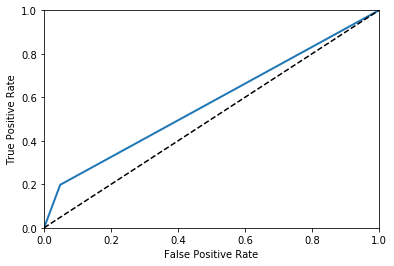

In [147]:
fpr, tpr, threshold = roc_curve(y_test,tf_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

### Tensorflow part II using important features from XGBoost and LightGBM

In [ ]:
#xgb_top_data
#lgb_top_data

X_train, X_test, y_train, y_test=train_test_split(data.iloc[:,1:],data.iloc[:,0], test_size=0.15, random_state=20)

In [153]:
%%time
X_train, X_test, y_train, y_test=train_test_split(xgb_top_data,data.iloc[:,0], test_size=0.15, random_state=20)
xbg_tf_model = tf.keras.Sequential([
    keras.layers.Dense(128,activation=tf.nn.relu),
    keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dense(32,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
  ])

xbg_tf_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
xbg_tf_model.fit(X_train,y_train.values,epochs=5)
tf_loss, tf_acc = xbg_tf_model.evaluate(X_test,y_test.values)
print("Test Acc: ",tf_acc)

Epoch 1/5
714986/714986 [==============================] - 69s 97us/step - loss: 0.4659 - acc: 0.7937
Epoch 2/5
714986/714986 [==============================] - 69s 96us/step - loss: 0.4617 - acc: 0.7948
Epoch 3/5
714986/714986 [==============================] - 70s 97us/step - loss: 0.4609 - acc: 0.7948
Epoch 4/5
714986/714986 [==============================] - 70s 98us/step - loss: 0.4603 - acc: 0.7951
Epoch 5/5
126174/126174 [==============================] - 5s 41us/step
Test Acc:  0.7959008987560224
Wall time: 5min 54s


In [154]:
%%time
X_train, X_test, y_train, y_test=train_test_split(lgb_top_data,data.iloc[:,0], test_size=0.15, random_state=20)
lbg_tf_model = tf.keras.Sequential([
    keras.layers.Dense(128,activation=tf.nn.relu),
    keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dense(32,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
  ])

lbg_tf_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
lbg_tf_model.fit(X_train,y_train.values,epochs=5)
tf_loss, tf_acc = lbg_tf_model.evaluate(X_test,y_test.values)
print("Test Acc: ",tf_acc)

Epoch 1/5
714986/714986 [==============================] - 68s 96us/step - loss: 0.4656 - acc: 0.7934
Epoch 2/5
714986/714986 [==============================] - 68s 95us/step - loss: 0.4611 - acc: 0.7949
Epoch 3/5
714986/714986 [==============================] - 69s 96us/step - loss: 0.4601 - acc: 0.7953
Epoch 4/5
714986/714986 [==============================] - 71s 99us/step - loss: 0.4596 - acc: 0.7956
Epoch 5/5
126174/126174 [==============================] - 5s 37us/step
Test Acc:  0.7962496235329178
Wall time: 5min 52s


In [ ]:
# stacking on LR, SVM, XGB, LGB, NN

In [ ]:
# comparison table for LR, SVM, XGB, LGB, NN, stacking
# on Acc, conf table, Precition, Recall, F1, ROC

In [ ]:
# for traning vs test plot -- https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

